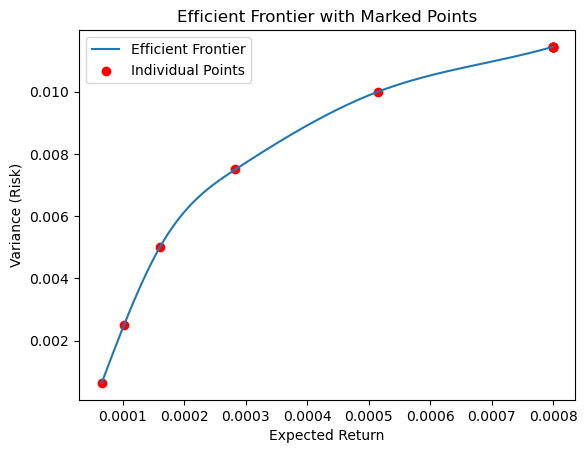

In [28]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Read and process data
df = pd.read_csv('RATES_ASSETS.csv')
df = df.apply(lambda col: col.fillna(col.mean()), axis=0)
col_arr = {}
arr_list = []
mu = []

for i in range(len(df.columns)):
    col_name = df.columns[i]
    col_arr[i+1] = df[col_name].to_numpy()
    mu.append(np.mean(col_arr[i+1]))
    arr_list.append(col_arr[i+1])

data_matrix = np.array(arr_list)

# Covariance matrix
cov_mat = np.cov(data_matrix)
e = np.ones(n)

# Objective function (minimize variance)
def objective(w):
    return w.T @ cov_mat @ w

# Constraint: eTw = 1 and wi >= 0
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # eTw = 1
               {'type': 'ineq', 'fun': lambda w: w}]            # w >= 0

w0 = np.ones(n) / n

# Minimize variance
result = minimize(objective, w0, method='SLSQP', constraints=constraints)
optimal_weights = []

optimal_weights.append(result.x)

# Compute optimal weights for different target returns
for i in range(1, 11):
    s = float(i / 400)

    def objective(w):
        return w.T @ cov_mat @ w

    # Constraints: eTw=1 and uTw=s
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # eTw = 1
                   {'type': 'eq', 'fun': lambda w: w.T @ mu - s},   # uTw = s
                   {'type': 'ineq', 'fun': lambda w: w}]            # w >= 0

    w0 = np.ones(n) / n

    # Minimize variance
    result = minimize(objective, w0, method='SLSQP', constraints=constraints)
    optimal_weights.append(result.x)
# for x and y coordinate as risk and return resp.
x = []
y = []
for i in range(0, 11):
    y.append(np.dot(optimal_weights[i].T, mu))  # Expected return
    x.append(np.dot(np.dot(optimal_weights[i].T, cov_mat), optimal_weights[i]))  # Variance

# Sort x and y for spline
x, y = zip(*sorted(zip(x, y)))
X_Y_Spline = make_interp_spline(x, y)
X_ = np.linspace(min(x), max(x), 500)
Y_ = X_Y_Spline(X_)

# Plot the smooth curve
plt.plot(X_, Y_, label='Efficient Frontier')

# Plot the points that we took
plt.scatter(x, y, color='red', marker='o', label='Individual Points')
plt.title("Efficient Frontier with Marked Points")
plt.xlabel("Expected Return")
plt.ylabel("Variance (Risk)")
plt.legend()
# show the curve
plt.show()